# Creative Extension Analysis

In this notebook, we propose a creative extension analysis of the paper _Friendship and Mobility: User Movement in Location-Based Social Networks_. We chose to answer multiple research questions by using the same datasets (check-ins) and an additional one (airports). 

In particular, we aim to find out:
- Which countries travel the most long distance by plane?
- Where do people from different countries travel to the most?
- Where users' friends are based?
- Is it possible to predict user home areas based on their long distance travel patterns?

## Tools

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import njit
import itertools

import reverse_geocoder
import pickle
import os

In [2]:
%load_ext blackcellmagic

## Load the Data

We load the check-ins datasets and the new airport dataset.

In [63]:
data_folder = "data"

checkins_b = pd.read_csv(
    os.path.join(data_folder, "loc-brightkite_totalCheckins.txt.gz"),
    compression="gzip",
    delimiter="\t",
    usecols=[0, 1, 2, 3],
    names=["user", "checkin_time", "latitude", "longitude"],
    parse_dates=["checkin_time"],
)

checkins_g = pd.read_csv(
    os.path.join(data_folder, "loc-gowalla_totalCheckins.txt.gz"),
    compression="gzip",
    delimiter="\t",
    usecols=[0, 1, 2, 3],
    names=["user", "checkin_time", "latitude", "longitude"],
    parse_dates=["checkin_time"],
)

airports = pd.read_csv(
    os.path.join(data_folder, "airports.csv"),
    usecols=[2, 3, 4, 5, 8],
)

countries = pd.read_csv(
    os.path.join(data_folder, "countries.csv"),
    usecols=[1, 2],
    header=0,
    names=["iso_country", "country"],
)

In the following cells, we will only display dataframes for Brightkite.

In [7]:
checkins_b.head()

user              checkin_time   latitude   longitude
0     0 2010-10-17 01:48:53+00:00  39.747652 -104.992510
1     0 2010-10-16 06:02:04+00:00  39.891383 -105.070814
2     0 2010-10-16 03:48:54+00:00  39.891077 -105.068532
3     0 2010-10-14 18:25:51+00:00  39.750469 -104.999073
4     0 2010-10-14 00:21:47+00:00  39.752713 -104.996337

## Preprocessing Check-ins Datasets

In [8]:
print(f"Brightkite checkins dataset has {len(checkins_b)} rows.")
print(f"Gowalla checkins dataset has {len(checkins_g)} rows.")

Brightkite checkins dataset has 4747287 rows.
Gowalla checkins dataset has 6442892 rows.


We check for missing values in both datasets

In [9]:
NaN_rows_b = np.count_nonzero(np.count_nonzero(checkins_b.isnull(), axis=1))
NaN_rows_g = np.count_nonzero(np.count_nonzero(checkins_g.isnull(), axis=1))
print(f"There are {NaN_rows_b} rows in Brightkite with at least a NaN value.")
print(f"There are {NaN_rows_g} rows in Gowalla with at least a NaN value.")
print("\nWhere the NaN values are in Brightkite:")
checkins_b.isnull().any()

There are 6 rows in Brightkite with at least a NaN value.
There are 0 rows in Gowalla with at least a NaN value.

Where the NaN values are in Brightkite:


user            False
checkin_time     True
latitude         True
longitude        True
dtype: bool

We see that Brightkite has just 6 rows with a NaN value. As we can see above thes NaN values are in the latitude and longitude column. We will remove the rows containg NaNs since these are probably some measuring mistakes.

In [10]:
checkins_b = checkins_b.dropna()

We notice that some values are incorrect in the datasets.  
Latitude should be bounded: $$ latitude \in [-90, 90]$$
Longitude should also be bounded: $$longitude \in [-180, 180]$$
We notice that both datasets have incorrect values only for their latitude:

In [12]:
wrong_lat_b = len(
    checkins_b[
        (checkins_b.latitude < -90)
        | (checkins_b.latitude > 90)
    ]
)
wrong_long_b = len(
    checkins_b[
        (checkins_b.longitude < -180)
        | (checkins_b.longitude > 180)
    ]
)
print(
    f"There are {wrong_lat_b} datapoints with an incorrect latitude\n and {wrong_long_b} with an incorrect longitude in the brightkite dataset."
)

wrong_lat_g = len(
    checkins_g[
        (checkins_g.latitude < -90)
        | (checkins_g.latitude > 90)
    ]
)
wrong_long_g = len(
    checkins_g[
        (checkins_g.longitude < -180)
        | (checkins_g.longitude > 180)
    ]
)
print(
    f"There are {wrong_lat_g} datapoints with an incorrect latitude\n and {wrong_long_g} with an incorrect longitude in the gowalla dataset."
)

There are 109 datapoints with an incorrect latitude
 and 0 with an incorrect longitude in the brightkite dataset.
There are 29 datapoints with an incorrect latitude
 and 0 with an incorrect longitude in the gowalla dataset.


The incorrect latitudes are probably some type of errors that happen unfrequently. As we can see there are only 109 and 29 incorrect coordinates in the BrightKite and Gowalla dataframe respectively. These might be measuring errors from the user's device or some conversion error or error while saving the coordinates in the Dataframe.

We can also see that there are check-ins at coordinate (0,0). These are probably outliers since these coordinates are in the middle of the Atlantic Ocean. Even though Gowalla only has a few, we will remove these datapoints in both datasets. Even though some datapoints in the datasets might not be outliers but just tourists visiting the virtual [Null Island](https://fr.wikipedia.org/wiki/Null_Island), we can safely assume that noone's home can be located there and we thus will remove all check-ins at (0,0).

In [13]:
number_00_checkins_b = len(
    checkins_b[
        (checkins_b.latitude == 0)
        & (checkins_b.longitude == 0)
    ]
)

number_00_checkins_g = len(
    checkins_g[
        (checkins_g.latitude == 0)
        & (checkins_g.longitude == 0)
    ]
)

print(
    f"There are {number_00_checkins_b} datapoints at coordinates (0,0) in the Brightkite dataset."
)

print(
    f"There are {number_00_checkins_g} datapoints at coordinates (0,0) in the Gowalla dataset."
)

There are 256137 datapoints at coordinates (0,0) in the Brightkite dataset.
There are 135 datapoints at coordinates (0,0) in the Gowalla dataset.


There are far more errors in the Brightkite dataset suggesting that there is some difference in the way the two services handle coordinates. A reason might be that these errors are due to users' devices but in this case it would mean that almost all users with faulty devices are in Brightkite and none are in Gowalla. This might be explained by the fact that Gowalla might have more requirements for users' devices before they download their service (better OS version, better sensors....).  
Another reason might be that Gowalla has some mechanism to detect fault measurements and remove them.  
Another reason might be that Brightkite might allow users to have the app without using their GPS and saves all checkins with default coordinate (0,0). This might sound strange but maybe they still want to save users' checkins even though they don't have GPS coordinates. In this case it would have been more reasonable to put some other value to indicate a lack of GPS coordinates (ex. NaN). 

We can now just keep the coordinates with correct values and not at (0,0):

In [14]:
checkins_b = checkins_b[
    (checkins_b.latitude >= -90)
    & (checkins_b.latitude <= 90)
    & ~((checkins_b.latitude == 0) & (checkins_b.longitude == 0))
]

checkins_g = checkins_g[
    (checkins_g.latitude >= -90)
    & (checkins_g.latitude <= 90)
    & ~((checkins_g.latitude == 0) & (checkins_g.longitude == 0))
]

In [15]:
checkins_b.head()

user              checkin_time   latitude   longitude
0     0 2010-10-17 01:48:53+00:00  39.747652 -104.992510
1     0 2010-10-16 06:02:04+00:00  39.891383 -105.070814
2     0 2010-10-16 03:48:54+00:00  39.891077 -105.068532
3     0 2010-10-14 18:25:51+00:00  39.750469 -104.999073
4     0 2010-10-14 00:21:47+00:00  39.752713 -104.996337

## Work on Airport Dataset

In [16]:
airports.head()

type                                name  latitude_deg  \
0       heliport                   Total Rf Heliport     40.070801   
1  small_airport                Aero B Ranch Airport     38.704022   
2  small_airport                        Lowell Field     59.949200   
3  small_airport                        Epps Airpark     34.864799   
4         closed  Newport Hospital & Clinic Heliport     35.608700   

   longitude_deg iso_country  
0     -74.933601          US  
1    -101.473911          US  
2    -151.695999          US  
3     -86.770302          US  
4     -91.254898          US

Wee see there are many different types of airports:

In [17]:
airports.type.value_counts()

small_airport     35218
heliport          12515
closed             4862
medium_airport     4538
seaplane_base      1039
large_airport       613
balloonport          25
Name: type, dtype: int64

We are only interested in airports, we check some examples of different types of airports in Switzerland:

In [18]:
airports[(airports.iso_country == "CH") & (airports.type == "small_airport")].head(5)

type                                  name  latitude_deg  \
15528  small_airport            Altiport de Croix de Coeur     46.123380   
15529  small_airport  Altisurface du Glacier de Prasfleuri     46.064289   
15530  small_airport    Altiport du Glacier de Tsanfleuron     46.320653   
34348  small_airport                           Bex Airport     46.258301   
34350  small_airport                    Ecuvillens Airport     46.755001   

       longitude_deg iso_country  
15528       7.234250          CH  
15529       7.354317          CH  
15530       7.232880          CH  
34348       6.986390          CH  
34350       7.076110          CH

In [19]:
airports[(airports.iso_country=='CH') & (airports.type=='medium_airport')].head(5)

type                   name  latitude_deg  longitude_deg  \
34349  medium_airport  Les Eplatures Airport     47.083900       6.792840   
34357  medium_airport           Sion Airport     46.219166       7.326944   
34363  medium_airport       Alpnach Air Base     46.943901       8.284170   
34364  medium_airport     Dübendorf Air Base     47.398602       8.648230   
34365  medium_airport         Emmen Air Base     47.092444       8.305184   

      iso_country  
34349          CH  
34357          CH  
34363          CH  
34364          CH  
34365          CH

In [20]:
airports[(airports.iso_country=='CH') & (airports.type=='large_airport')].head(5)

type                                   name  latitude_deg  \
34351  large_airport  Geneva Cointrin International Airport     46.238098   
34411  large_airport                         Zürich Airport     47.464699   

       longitude_deg iso_country  
34351        6.10895          CH  
34411        8.54917          CH

We are only interested in large airports, so we only keep them:

In [21]:
airports = airports[(airports.type == "large_airport")]
airports = airports.drop(columns="type")

We check the countries with most large airports.

In [22]:
airports.iso_country.value_counts().head(5)

US    170
CN     35
GB     27
RU     19
IT     17
Name: iso_country, dtype: int64

We now merge with the `countries` DataFrame to get the name of each country for each airport:

In [23]:
countries.head()

iso_country               country
0          AD               Andorra
1          AE  United Arab Emirates
2          AF           Afghanistan
3          AG   Antigua and Barbuda
4          AI              Anguilla

We first check for NA values and remove the correspoinding rows:

In [24]:
print(countries.isna().sum())
countries = countries.dropna()

iso_country    1
country        0
dtype: int64


In [25]:
airports = airports.merge(countries)
airports.head()

name  latitude_deg  longitude_deg  \
0  Port Moresby Jacksons International Airport     -9.443380     147.220001   
1               Keflavik International Airport     63.985001     -22.605600   
2               Priština International Airport     42.572800      21.035801   
3                               Guodu air base     36.001741     117.632010   
4         Yantai Penglai International Airport     37.657222     120.987222   

  iso_country           country  
0          PG  Papua New Guinea  
1          IS           Iceland  
2          XK            Kosovo  
3          CN             China  
4          CN             China

### Finding the home of each user

We use the following [formulas](https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance) to transform latitude and longitude into kilometers.

- **Latitude: 1 deg = 110.574 km**  
- **Longitude: 1 deg = 111.320*cos(latitude) km**

We will divide the world according to 25km*25km squares. Each cell will be identified using a unique number. We first define two indices per box: $x,y\in \mathbb{Z}$  
The box (0,0) will be the box with lower left (i.e southwest) coordinate (0,0).  
X indexes grow when going east. $x \in [-N, N]$.  
Y indexes grow north. $y \in [-M, M]$

Then we create a unique number using [Cantor pairing function](https://en.wikipedia.org/wiki/Pairing_function#Cantor_pairing_function):
$$f(n_1, n_2) = \frac{1}{2}(n_2 + n_1)(n_2+n_1+1)+n_1$$

We use [njit](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html) to make the calculations faster.

In [26]:
@njit
def assign_cell(latitude, longitude):
    """
    Assign a cell_number based on the cantor pairing function and discretization into 25km * 25km cells.

    Arguments
    =========
    latitude : float
        latitude in degrees.
    longitude : float
        longitude in degrees.

    Returns
    =======
    cell_number : int
        Cell number based on the cantor pair function.
    """

    km_east = 111.320 * np.cos(np.deg2rad(latitude)) * longitude
    km_north = 110.574 * latitude
    x_index = km_east // 25
    y_index = km_north // 25
    cell_number = (1/2)*(y_index + x_index)*(y_index + x_index + 1) + x_index
    return cell_number

In [27]:
checkins_b["cell_number"] = assign_cell(checkins_b["latitude"].values, checkins_b["longitude"].values)
checkins_g["cell_number"] = assign_cell(checkins_g["latitude"].values, checkins_g["longitude"].values)

checkins_b["cell_number"] = checkins_b["cell_number"].astype('int')
checkins_g["cell_number"] = checkins_g["cell_number"].astype('int')

The goal of the step below is to find the box_index with most check-ins for each user. To do this, we:
1. Group by user and box_index and get the counts.
2. We sort these counts and take the biggest for each user.
3. We recreate a DataFrame from the Serie we now have.
4. We sort the DataFrame by user and make ["user", "box_index"] the only columns.

In [28]:
user_cell_b = (
    checkins_b.groupby(by=["user", "cell_number"])
    .size()
    .sort_values()
    .groupby(level=0)
    .tail(1)
    .to_frame()
    .sort_values("user")
    .reset_index()
    .drop(columns=0)
)

user_cell_g = (
    checkins_g.groupby(by=["user", "cell_number"])
    .size()
    .sort_values()
    .groupby(level=0)
    .tail(1)
    .to_frame()
    .sort_values("user")
    .reset_index()
    .drop(columns=0)
)

user_cell_b.head()

user  cell_number
0     0        16660
1     1        34813
2     2        16660
3     3        34813
4     4        51736

We create a new dataframe to have the home coordinates of each user. (Recall: home coordinates are the average location of check-ins in the most visited box per user).

In [29]:
homes_b = (
    user_cell_b.merge(checkins_b).groupby("user").mean()
)

homes_g = (
    user_cell_g.merge(checkins_g).groupby("user").mean()
)

In [30]:
homes_b.head()

cell_number   latitude   longitude
user                                    
0           16660  39.746677 -104.973619
1           34813  37.602712 -122.377186
2           16660  39.738340 -104.960762
3           34813  37.670403 -122.406295
4           51736  60.173672   24.942450

### Find the country of residence for each user

We want to retrieve the country of residence of each user. To do so, we will collect all cells in which there is at least one home. Then we assume all homes in one cell are from one country. To minimize errors due to this 25km x 25km discretization we will identify each cell by the average checkin position of all checkins inside the cell. This way if a cell is between two countries and most checkins are on one side of the border we will define the majority of homes in the country where the most checkins happened.

We create a function which will return the country code given a point coordinates.

In [31]:
center_cells_b = checkins_b[['latitude', 'longitude', 'cell_number']].groupby('cell_number').mean()
center_cells_g = checkins_g[['latitude', 'longitude', 'cell_number']].groupby('cell_number').mean()

center_cells_b = center_cells_b.reset_index()
center_cells_g = center_cells_g.reset_index()

In [32]:
center_cells_b.head()

cell_number   latitude   longitude
0         -286  64.545703 -149.087119
1         -284  64.152500 -145.842222
2         -282  63.562699 -142.300615
3         -280  63.934833 -145.788211
4         -279  63.661389 -144.064444

In [33]:
home_countries_b = homes_b.merge(center_cells_b, on='cell_number', suffixes=["_home", "_cell"])
home_countries_g = homes_g.merge(center_cells_g, on='cell_number', suffixes=["_home", "_cell"])

In [34]:
home_countries_b = home_countries_b.drop(columns=["latitude_home", "longitude_home"])
home_countries_g = home_countries_g.drop(columns=["latitude_home", "longitude_home"])

home_countries_b = home_countries_b.drop_duplicates()
home_countries_g = home_countries_g.drop_duplicates()

In [35]:
home_countries_b.head()

cell_number  latitude_cell  longitude_cell
0           16660      39.731991     -104.980205
751         34813      37.626781     -122.389266
974         51736      60.183202       24.943493
1179         5274      41.911515      -87.676377
1780        20922      43.590722        3.737697

In [36]:
def retrieve_country(lat, lon):
    """
    Return the ISO country code of a point in space

    Arguments
    =========
        lat : float
            Latitude of the point
        lon : float
            Longitude of the point

    Returns
    =======
        str
            ISO country code of the point

    """

    return reverse_geocoder.search((lat, lon))[0]["cc"]


# vectorize the function
retrieve_country_vec = np.vectorize(retrieve_country)

The following cell takes a lot of time, so we pickled it.

In [33]:
# home_countries_b["country"] = retrieve_country_vec(
#    home_countries_b["latitude_cell"], home_countries_b["longitude_cell"]
# )

# home_countries_g["country"] = retrieve_country_vec(
#    home_countries_g["latitude_cell"], home_countries_g["longitude_cell"]
# )

In [34]:
# home_countries_b.to_pickle(os.path.join(data_folder, 'home_countries_b.pkl'))
# home_countries_g.to_pickle(os.path.join(data_folder, 'home_countries_g.pkl'))

In [37]:
home_countries_b = pd.read_pickle(os.path.join(data_folder, "home_countries_b.pkl"))
home_countries_g = pd.read_pickle(os.path.join(data_folder, "home_countries_g.pkl"))

In [38]:
home_countries_b.head()

cell_number  latitude_cell  longitude_cell country
0           16660      39.731991     -104.980205      US
751         34813      37.626781     -122.389266      US
974         51736      60.183202       24.943493      FI
1179         5274      41.911515      -87.676377      US
1780        20922      43.590722        3.737697      FR

Now that we have for each 'home' the country code, we can now merge the two datasets so that we have a complete dataframe.

In [39]:
homes_b = homes_b.reset_index().merge(home_countries_b, on='cell_number')
homes_g = homes_g.reset_index().merge(home_countries_g, on="cell_number")

homes_b = homes_b.drop(columns = ['latitude_cell', 'longitude_cell'])
homes_g = homes_g.drop(columns=["latitude_cell", "longitude_cell"])

In [40]:
homes_g.sample(10)

user  cell_number   latitude   longitude country
46439    78976        10430  34.853227  -82.258708      US
100277  149312        29504  32.010896 -102.143989      US
77785     8388        26565  52.203544    0.135404      GB
39444   164282        40214  57.693945   11.929718      SE
101513   66158        18019  28.357973  -80.696643      US
7142     67663        35079  37.435669 -122.070227      US
50597    30835          893  42.333099  -71.250876      US
65494   120388        26327  53.764052   -3.011682      GB
39090   139540        40214  57.700704   11.973035      SE
55596   102799         1779  53.513106 -113.515384      CA

### Detect long distance travel

We are using the following heuristic to detect a long distance travel. If two consecutive checkins of a same user happen at a distance of more than 500km, we assume a long dictance trip occured and we can safely assume most of those happened by plane.

To do that we will:
1. Sort checkins by user and time.
2. Filter and keep only checkins that happen just before and after a long distance travel

In [41]:
checkins_b = checkins_b.sort_values(by=["user", "checkin_time"])
checkins_g = checkins_g.sort_values(by=["user", "checkin_time"])

In [42]:
long_distance_travel_b = checkins_b.reset_index().merge(
    checkins_b.shift(-1).dropna().reset_index(),
    on="index",
    suffixes=("_start", "_end"),
)

long_distance_travel_b = long_distance_travel_b[
    long_distance_travel_b.user_start == long_distance_travel_b.user_end
]
long_distance_travel_b = long_distance_travel_b.drop(columns=["index"])

long_distance_travel_g = checkins_g.reset_index().merge(
    checkins_g.shift(-1).dropna().reset_index(),
    on="index",
    suffixes=("_start", "_end"),
)

long_distance_travel_g = long_distance_travel_g[
    long_distance_travel_g.user_start == long_distance_travel_g.user_end
]
long_distance_travel_g = long_distance_travel_g.drop(columns=["index"])

In [43]:
long_distance_travel_b.user_end = long_distance_travel_b.user_end.astype("int")
long_distance_travel_b.cell_number_end = long_distance_travel_b.cell_number_end.astype("int")

long_distance_travel_g.user_end = long_distance_travel_g.user_end.astype("int")
long_distance_travel_g.cell_number_end = long_distance_travel_g.cell_number_end.astype("int")

long_distance_travel_b.head()

user_start        checkin_time_start  latitude_start  longitude_start  \
0           0 2009-05-25 20:56:10+00:00       37.774929      -122.419415   
1           0 2009-05-25 21:35:28+00:00       37.600747      -122.382376   
2           0 2009-05-25 21:37:44+00:00       37.600747      -122.382376   
3           0 2009-05-25 21:42:47+00:00       37.600747      -122.382376   
4           0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start  user_end          checkin_time_end  latitude_end  \
0              34285         0 2009-05-25 21:35:28+00:00     37.600747   
1              34813         0 2009-05-25 21:37:44+00:00     37.600747   
2              34813         0 2009-05-25 21:42:47+00:00     37.600747   
3              34813         0 2009-05-25 22:13:23+00:00     37.615223   
4              34813         0 2009-05-26 02:21:12+00:00     39.878664   

   longitude_end  cell_number_end  
0    -122.382376            34813  
1    -122.382376            34813  
2    -122.382376            34813  
3    -122.389979            34813  
4    -104.682105            16113

The formulas for the function below are from [stackoverflow](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude).

In [44]:
@njit
def distance_between_two_coordinates(
    lat1_degrees, lon1_degrees, lat2_degrees, lon2_degrees
):
    """
    Distance in km between two points given in coordinates.

    Arguments
    =========
    lat1_degrees : float
        latitude of the first point in degrees.
    lon1_degrees : float
        longitude of the first point in degrees.
    lat2_degrees : float
        latitude of the second point in degrees.
    lon2_degrees : float
        longitude of the second point in degrees.

    Returns
    =======
    distance : float
        distance in km between the two coordiantes.
    """

    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.deg2rad(lat1_degrees)
    lon1 = np.deg2rad(lon1_degrees)
    lat2 = np.deg2rad(lat2_degrees)
    lon2 = np.deg2rad(lon2_degrees)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

In [45]:
long_distance_travel_b["distance"] = distance_between_two_coordinates(
    long_distance_travel_b.latitude_start.values,
    long_distance_travel_b.longitude_start.values,
    long_distance_travel_b.latitude_end.values,
    long_distance_travel_b.longitude_end.values,
)

long_distance_travel_g["distance"] = distance_between_two_coordinates(
    long_distance_travel_g.latitude_start.values,
    long_distance_travel_g.longitude_start.values,
    long_distance_travel_g.latitude_end.values,
    long_distance_travel_g.longitude_end.values,
)

In [46]:
MIN_DISTANCE_PLANE = 500
long_distance_travel_b = long_distance_travel_b[long_distance_travel_b.distance >= MIN_DISTANCE_PLANE]
long_distance_travel_g = long_distance_travel_g[long_distance_travel_g.distance >= MIN_DISTANCE_PLANE]

In [47]:
long_distance_travel_b = long_distance_travel_b.rename(columns = {'user_start' : 'user'}).drop(columns='user_end')
long_distance_travel_g = long_distance_travel_g.rename(columns = {'user_start' : 'user'}).drop(columns='user_end')

In [48]:
long_distance_travel_b.sample(5)

user        checkin_time_start  latitude_start  longitude_start  \
551975    1570 2008-10-05 12:44:08+00:00       41.299682       -95.898552   
3047142  14174 2008-05-21 18:24:49+00:00       37.757757      -122.388243   
558211    1693 2010-01-04 02:01:18+00:00       41.928687       -72.683873   
446869    1117 2009-10-12 02:21:31+00:00       28.372518       -81.513221   
380810     878 2010-04-28 05:16:24+00:00       43.643693       -79.381185   

         cell_number_start          checkin_time_end  latitude_end  \
551975                9270 2008-10-05 14:15:02+00:00     39.739154   
3047142              34285 2008-05-26 21:48:16+00:00     33.748995   
558211                1299 2010-01-06 18:24:11+00:00     36.132252   
446869               18595 2009-10-12 02:25:27+00:00     37.893425   
380810                1697 2010-04-30 01:40:39+00:00     39.759189   

         longitude_end  cell_number_end     distance  
551975     -104.984703            16660   787.240770  
3047142     -84.387982            13053  3435.380940  
558211     -115.154796            32225  3687.425631  
446869     -122.123799            34023  3894.846185  
380810     -105.009615            16660  2162.639117

We now want to find the closest airport to start and end point of each long distance travel:

We need a dummy key to do the crossproduct of the two DataFrames.

In [49]:
long_distance_travel_b["key"] = 0
airports["key"] = 0

travel_airports_b = (
    long_distance_travel_b.reset_index().merge(airports, how="outer")
    .drop(columns="key")
    .rename(
        columns={
            "latitude_deg": "latitude_airport",
            "longitude_deg": "longitude_airport",
        }
    )
)

In [50]:
long_distance_travel_g["key"] = 0

travel_airports_g = (
    long_distance_travel_g.reset_index().merge(airports, how="outer")
    .drop(columns="key")
    .rename(
        columns={
            "latitude_deg": "latitude_airport",
            "longitude_deg": "longitude_airport",
        }
    )
)

In [51]:
travel_airports_b.head()

index  user        checkin_time_start  latitude_start  longitude_start  \
0      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
2      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
3      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
4      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start          checkin_time_end  latitude_end  longitude_end  \
0              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
1              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
2              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
3              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
4              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   

   cell_number_end     distance                                         name  \
0            16113  1553.988792  Port Moresby Jacksons International Airport   
1            16113  1553.988792               Keflavik International Airport   
2            16113  1553.988792               Priština International Airport   
3            16113  1553.988792                               Guodu air base   
4            16113  1553.988792         Yantai Penglai International Airport   

   latitude_airport  longitude_airport iso_country           country  
0         -9.443380         147.220001          PG  Papua New Guinea  
1         63.985001         -22.605600          IS           Iceland  
2         42.572800          21.035801          XK            Kosovo  
3         36.001741         117.632010          CN             China  
4         37.657222         120.987222          CN             China

We now want to calculate the distance between each airport and the start and end checkin of each travel.

In [52]:
travel_airports_b["distance_airport_start"] = distance_between_two_coordinates(
    travel_airports_b.latitude_start.values,
    travel_airports_b.longitude_start.values,
    travel_airports_b.latitude_airport.values,
    travel_airports_b.longitude_airport.values,
)

travel_airports_b["distance_airport_end"] = distance_between_two_coordinates(
    travel_airports_b.latitude_end.values,
    travel_airports_b.longitude_end.values,
    travel_airports_b.latitude_airport.values,
    travel_airports_b.longitude_airport.values,
)

In [53]:
travel_airports_g["distance_airport_start"] = distance_between_two_coordinates(
    travel_airports_g.latitude_start.values,
    travel_airports_g.longitude_start.values,
    travel_airports_g.latitude_airport.values,
    travel_airports_g.longitude_airport.values,
)

travel_airports_g["distance_airport_end"] = distance_between_two_coordinates(
    travel_airports_g.latitude_end.values,
    travel_airports_g.longitude_end.values,
    travel_airports_g.latitude_airport.values,
    travel_airports_g.longitude_airport.values,
)

In [54]:
travel_airports_b.head(2)

index  user        checkin_time_start  latitude_start  longitude_start  \
0      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   

   cell_number_start          checkin_time_end  latitude_end  longitude_end  \
0              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
1              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   

   cell_number_end     distance                                         name  \
0            16113  1553.988792  Port Moresby Jacksons International Airport   
1            16113  1553.988792               Keflavik International Airport   

   latitude_airport  longitude_airport iso_country           country  \
0         -9.443380         147.220001          PG  Papua New Guinea   
1         63.985001         -22.605600          IS           Iceland   

   distance_airport_start  distance_airport_end  
0            10684.045260          12223.989176  
1             6751.003459           5727.644170

In [55]:
def create_rename_dict(suffix):
    rename_dict = {
        "name": "name_"+suffix,
        "latitude_airport": "latitude_airport_"+suffix,
        "longitude_airport": "longitude_airport_"+suffix,
        "iso_country": "iso_country_"+suffix,
        "country": "country_"+suffix,
    }
    return rename_dict

In [56]:
start_travel_b = travel_airports_b[
    travel_airports_b.groupby(["index"])["distance_airport_start"].transform(min)
    == travel_airports_b["distance_airport_start"]
]

start_travel_b = start_travel_b.drop(columns="distance_airport_end").rename(
    columns=create_rename_dict('start')
)


end_travel_b = travel_airports_b[
    travel_airports_b.groupby(["index"])["distance_airport_end"].transform(min)
    == travel_airports_b["distance_airport_end"]
]

end_travel_b = end_travel_b.drop(columns="distance_airport_start").rename(
    columns=create_rename_dict('end')
)

In [57]:
start_travel_g = travel_airports_g[
    travel_airports_g.groupby(["index"])["distance_airport_start"].transform(min)
    == travel_airports_g["distance_airport_start"]
]

start_travel_g = start_travel_g.drop(columns="distance_airport_end").rename(
    columns=create_rename_dict('start')
)


end_travel_g = travel_airports_g[
    travel_airports_g.groupby(["index"])["distance_airport_end"].transform(min)
    == travel_airports_g["distance_airport_end"]
]

end_travel_g = end_travel_g.drop(columns="distance_airport_start").rename(
    columns=create_rename_dict('end')
)

In [58]:
start_travel_b.head(2)

index  user        checkin_time_start  latitude_start  longitude_start  \
328      4     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
842    178     0 2009-06-15 13:51:19+00:00       39.848233      -104.675031   

     cell_number_start          checkin_time_end  latitude_end  longitude_end  \
328              34813 2009-05-26 02:21:12+00:00     39.878664    -104.682105   
842              16113 2009-06-15 17:19:41+00:00     33.944066    -118.408294   

     cell_number_end     distance                           name_start  \
328            16113  1553.988792  San Francisco International Airport   
842            40890  1384.735707         Denver International Airport   

     latitude_airport_start  longitude_airport_start iso_country_start  \
328               37.618999              -122.375000                US   
842               39.861698              -104.672997                US   

     country_start  distance_airport_start  
328  United States                1.384977  
842  United States                1.507768

In [59]:
travels_b = start_travel_b.merge(end_travel_b)
travels_b = travels_b[
    ~(travels_b.distance_airport_start > 1000) | (travels_b.distance_airport_end > 1000)
]

travels_b = travels_b.merge(
    homes_b[["user", "country"]].rename(columns={"country": "country_user"})
)
travels_b["month"] = travels_b.checkin_time_end.dt.month
travels_b["year"] = travels_b.checkin_time_end.dt.year
travels_b = travels_b.drop(columns=["index", "cell_number_start", "cell_number_end"])

In [60]:
travels_g = start_travel_g.merge(end_travel_g)
travels_g = travels_g[
    ~(travels_g.distance_airport_start > 1000) | (travels_g.distance_airport_end > 1000)
]

travels_g = travels_g.merge(
    homes_g[["user", "country"]].rename(columns={"country": "country_user"})
)
travels_g["month"] = travels_g.checkin_time_end.dt.month
travels_g["year"] = travels_g.checkin_time_end.dt.year
travels_g = travels_g.drop(columns=["index", "cell_number_start", "cell_number_end"])

In [61]:
travels_b.head(2)

user        checkin_time_start  latitude_start  longitude_start  \
0     0 2009-05-25 22:13:23+00:00       37.615223      -122.389979   
1     0 2009-06-15 13:51:19+00:00       39.848233      -104.675031   

           checkin_time_end  latitude_end  longitude_end     distance  \
0 2009-05-26 02:21:12+00:00     39.878664    -104.682105  1553.988792   
1 2009-06-15 17:19:41+00:00     33.944066    -118.408294  1384.735707   

                            name_start  latitude_airport_start  ...  \
0  San Francisco International Airport               37.618999  ...   
1         Denver International Airport               39.861698  ...   

   distance_airport_start                           name_end  \
0                1.384977       Denver International Airport   
1                1.507768  Los Angeles International Airport   

  latitude_airport_end  longitude_airport_end iso_country_end    country_end  \
0            39.861698            -104.672997              US  United States   
1            33.942501            -118.407997              US  United States   

   distance_airport_end country_user month  year  
0              2.041031           US     5  2009  
1              0.176219           US     6  2009  

[2 rows x 23 columns]

In [62]:
# travels_b.to_pickle(os.path.join(data_folder, 'travels_b.pkl'))
# travels_g.to_pickle(os.path.join(data_folder, 'travels_g.pkl'))

# travels_b = pd.read_pickle(os.path.join(data_folder, 'travels_b.pkl'))
# travels_g = pd.read_pickle(os.path.join(data_folder, 'travels_g.pkl'))

## Research Questions

### Which countries travel the most long distance by plane?

We first want to see how many times each month appears so that we can normalize the data for one year.

In [94]:
months_counts_b = travels_b.groupby('month').agg({'year' : lambda x : len(x.unique())})
months_counts_g = travels_g.groupby('month').agg({'year' : lambda x : len(x.unique())})
months_counts_b

year
month      
1         2
2         2
3         3
4         3
5         3
6         3
7         3
8         3
9         3
10        3
11        2
12        2

We then want to fnd how many users we have per country so we can then normalize the data per country per number of users in that country:

In [166]:
users_by_country_b = homes_b.groupby('country').agg({'user' : 'count'})
users_by_country_g = homes_g.groupby('country').agg({'user' : 'count'})
users_by_country = pd.concat( [users_by_country_b.reset_index(), users_by_country_g.reset_index()], axis=0, ignore_index=True)
users_by_country = users_by_country_b.groupby('country').agg({'user' : 'sum'}).rename(columns={'user' : 'user_count'})

users_by_country.sort_values('user_count', ascending = False).head(5)

user_count
country            
US            30633
GB             3238
JP             2866
AU             1451
CA             1432

We first normalize the data of Brightkite and Gowalla by month and users separetely and then merge them:

In [187]:
yearly_travels_b = (
    travels_b.groupby(["country_user", "month"])["distance"]
    .agg(["sum", "count"])
    .sort_values("count", ascending=False)
    .rename(columns={"sum": "distance"})
)

yearly_travels_b = yearly_travels_b.reset_index().merge(months_counts_b.reset_index())

yearly_travels_b["distance_normalized"] = (
    yearly_travels_b["distance"] / yearly_travels_b["year"]
)

yearly_travels_b["count_normalized"] = (
    yearly_travels_b["count"] / yearly_travels_b["year"]
)

yearly_travels_g = (
    travels_g.groupby(["country_user", "month"])["distance"]
    .agg(["sum", "count"])
    .sort_values("count", ascending=False)
    .rename(columns={"sum": "distance"})
)

yearly_travels_g = yearly_travels_g.reset_index().merge(months_counts_g.reset_index())

yearly_travels_g["distance_normalized"] = (
    yearly_travels_g["distance"] / yearly_travels_g["year"]
)

yearly_travels_g["count_normalized"] = (
    yearly_travels_g["count"] / yearly_travels_g["year"]
)


yearly_travels_b.head()

country_user  month      distance  count  year  distance_normalized  \
0           US      6  1.751971e+07   6887     3         5.839903e+06   
1           JP      6  1.601110e+06    404     3         5.337032e+05   
2           GB      6  1.302044e+06    338     3         4.340146e+05   
3           AU      6  1.216489e+06    219     3         4.054965e+05   
4           CA      6  4.117209e+05    160     3         1.372403e+05   

   count_normalized  
0       2295.666667  
1        134.666667  
2        112.666667  
3         73.000000  
4         53.333333

In [188]:
yearly_travels = (
    yearly_travels_b.append(yearly_travels_g, ignore_index=True)
    .groupby(["country_user", "month"])
    .sum()
    .drop(columns=["year"])
    .reset_index()
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AD      7   6881.966417      2          3440.983209   
1           AD      9   6878.186953      2          3439.093477   
2           AE      1  43223.572732      4         23635.346534   
3           AE      2  23213.961991      7         16473.655541   
4           AE      3  35038.451976     12         14982.519175   

   count_normalized  
0          1.000000  
1          1.000000  
2          2.500000  
3          5.000000  
4          5.333333

In [189]:
yearly_travels = yearly_travels.merge(
    users_by_country, left_on="country_user", right_on="country"
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AE      1  43223.572732      4         23635.346534   
1           AE      2  23213.961991      7         16473.655541   
2           AE      3  35038.451976     12         14982.519175   
3           AE      4  46843.504488     15         21508.708244   
4           AE      5  97011.963295     17         42027.201673   

   count_normalized  user_count  
0          2.500000          38  
1          5.000000          38  
2          5.333333          38  
3          6.833333          38  
4          7.666667          38

In [190]:
yearly_travels["distance_normalized"] = (
    yearly_travels["distance_normalized"] / yearly_travels["user_count"]
)

yearly_travels["count_normalized"] = (
    yearly_travels["count_normalized"] / yearly_travels["user_count"]
)

yearly_travels.head()

country_user  month      distance  count  distance_normalized  \
0           AE      1  43223.572732      4           621.982804   
1           AE      2  23213.961991      7           433.517251   
2           AE      3  35038.451976     12           394.276820   
3           AE      4  46843.504488     15           566.018638   
4           AE      5  97011.963295     17          1105.978991   

   count_normalized  user_count  
0          0.065789          38  
1          0.131579          38  
2          0.140351          38  
3          0.179825          38  
4          0.201754          38

We can now see the data throughout a whole year and see which countries travel the most in terms of:
- Flown distance
- Number of trips

We remove countries where we have less than 100 users because they are not representative enough.

In [195]:
aggregated_yearly_travels = yearly_travels.groupby("country_user").agg(
    {
        "distance": "sum",
        "count": "sum",
        "distance_normalized": "sum",
        "count_normalized": "sum",
        "user_count": "first",
    }
)

In [196]:
aggregated_yearly_travels[aggregated_yearly_travels.user_count > 100].sort_values(
    "distance_normalized", ascending=False
).head(10)

distance   count  distance_normalized  count_normalized  \
country_user                                                                
SE            3.279110e+07   15770         21392.997069         10.091975   
SG            3.236598e+06     715         10043.526581          2.244376   
CH            3.785384e+06    1324          8889.912591          3.081359   
NO            9.954720e+06    4740          7954.212618          3.816694   
AT            1.782778e+06     673          6457.808263          2.469136   
PH            2.045927e+06     431          6235.337167          1.377252   
BE            3.250453e+06    1279          6221.406565          2.438662   
US            3.534831e+08  161543          5546.445850          2.580909   
CN            3.768523e+06     982          4973.747034          1.332825   
AU            1.635049e+07    3778          4930.322180          1.188835   

              user_count  
country_user              
SE                   839  
SG                   163  
CH                   211  
NO                   601  
AT                   135  
PH                   148  
BE                   269  
US                 30633  
CN                   328  
AU                  1451

In [197]:
aggregated_yearly_travels[aggregated_yearly_travels.user_count > 100].sort_values(
    "count_normalized", ascending=False
).head(10)

distance   count  distance_normalized  count_normalized  \
country_user                                                                
SE            3.279110e+07   15770         21392.997069         10.091975   
NO            9.954720e+06    4740          7954.212618          3.816694   
CH            3.785384e+06    1324          8889.912591          3.081359   
US            3.534831e+08  161543          5546.445850          2.580909   
AT            1.782778e+06     673          6457.808263          2.469136   
BE            3.250453e+06    1279          6221.406565          2.438662   
SG            3.236598e+06     715         10043.526581          2.244376   
DE            1.320169e+07    5155          4706.190980          1.908234   
DK            1.839942e+06     724          4305.535380          1.757500   
MX            1.097620e+06     473          3931.382028          1.742092   

              user_count  
country_user              
SE                   839  
NO                   601  
CH                   211  
US                 30633  
AT                   135  
BE                   269  
SG                   163  
DE                  1344  
DK                   200  
MX                   137

### Where do people from different countries travel to the most?

In [365]:
len(travels_b[~((travels_b.country_user == travels_b.iso_country_end) & (travels_b.iso_country_end != travels_b.iso_country_start))])

85232

In [380]:
travels_b[(travels_b.iso_country_start == 'LU') & (travels_b.iso_country_end == 'LU')]

Empty DataFrame
Columns: [user, checkin_time_start, latitude_start, longitude_start, checkin_time_end, latitude_end, longitude_end, distance, name_start, latitude_airport_start, longitude_airport_start, iso_country_start, country_start, distance_airport_start, name_end, latitude_airport_end, longitude_airport_end, iso_country_end, country_end, distance_airport_end, country_user, month, year]
Index: []

[0 rows x 23 columns]

In [382]:
travels_not_home_returns_b = travels_b[
    ~(
        (travels_b.country_user == travels_b.iso_country_end)
        & (travels_b.iso_country_end != travels_b.iso_country_start)
    )
]

end_country_b = (
    travels_not_home_returns_b.groupby(["country_user", "iso_country_end", "month"])
    .agg({"user": "count"})
    .rename(columns={"user": "number_of_trips"})
    .reset_index()
)

end_country_b = end_country_b.merge(months_counts_b.reset_index())

end_country_b["number_of_trips_normalized"] = (
    end_country_b["number_of_trips"] / end_country_b["year"]
)
end_country_b = (
    end_country_b.groupby(["country_user", "iso_country_end"])
    .agg({"number_of_trips_normalized": "sum"})
    .reset_index()
)


travels_not_home_returns_g = travels_g[
    ~(
        (travels_g.country_user == travels_g.iso_country_end)
        & (travels_g.iso_country_end != travels_g.iso_country_start)
    )
]

end_country_g = (
    travels_not_home_returns_g.groupby(["country_user", "iso_country_end", "month"])
    .agg({"user": "count"})
    .rename(columns={"user": "number_of_trips"})
    .reset_index()
)

end_country_g = end_country_g.merge(months_counts_g.reset_index())

end_country_g["number_of_trips_normalized"] = (
    end_country_g["number_of_trips"] / end_country_g["year"]
)
end_country_g = (
    end_country_g.groupby(["country_user", "iso_country_end"])
    .agg({"number_of_trips_normalized": "sum"})
    .reset_index()
)

end_country_b

country_user iso_country_end  number_of_trips_normalized
0              AE              BE                    0.500000
1              AE              CA                    0.333333
2              AE              CK                    0.500000
3              AE              CR                    0.333333
4              AE              DE                    0.333333
...           ...             ...                         ...
2110           ZA              US                    2.833333
2111           ZA              ZA                    7.833333
2112           ZA              ZM                    0.500000
2113           ZA              ZW                    0.333333
2114           ZM              BR                    0.333333

[2115 rows x 3 columns]

In [383]:
end_country = end_country_b.append(end_country_g, ignore_index=True)
end_country = (
    end_country.groupby(["country_user", "iso_country_end"])
    .sum()
    .reset_index()
    .sort_values("number_of_trips_normalized", ascending=False)
)

end_country

country_user iso_country_end  number_of_trips_normalized
2982           US              US                70127.000000
1626           JP              JP                 1538.666667
2564           SE              SE                 1368.333333
133            AU              AU                 1020.500000
2499           SE              DK                  975.000000
...           ...             ...                         ...
1751           LU              FI                    0.333333
1754           LU              ID                    0.333333
1756           LU              LT                    0.333333
1757           LU              LV                    0.333333
3072           ZM              BR                    0.333333

[3073 rows x 3 columns]

In [384]:
total_normalized_trips = (
    end_country.groupby("country_user")[["number_of_trips_normalized"]]
    .sum()
    .reset_index()
    .rename(columns={"number_of_trips_normalized": "total_number_of_trips_normalized"})
)

end_country = end_country.merge(total_normalized_trips)
end_country["percentage_trips"] = end_country["number_of_trips_normalized"] / end_country["total_number_of_trips_normalized"]
end_country.head()

country_user iso_country_end  number_of_trips_normalized  \
0           US              US                70127.000000   
1           US              CA                  736.500000   
2           US              GB                  615.166667   
3           US              MX                  298.333333   
4           US              DE                  271.666667   

   total_number_of_trips_normalized  percentage_trips  
0                      75469.166667          0.929214  
1                      75469.166667          0.009759  
2                      75469.166667          0.008151  
3                      75469.166667          0.003953  
4                      75469.166667          0.003600

In [385]:
top_end_country = end_country.groupby(
    "country_user"
).head(
    10
)
top_end_country

country_user iso_country_end  number_of_trips_normalized  \
0              US              US                70127.000000   
1              US              CA                  736.500000   
2              US              GB                  615.166667   
3              US              MX                  298.333333   
4              US              DE                  271.666667   
...           ...             ...                         ...   
3068           IQ              US                    0.333333   
3069           IQ              ES                    0.333333   
3070           MD              JP                    0.333333   
3071           ML              US                    0.333333   
3072           ZM              BR                    0.333333   

      total_number_of_trips_normalized  percentage_trips  
0                         75469.166667          0.929214  
1                         75469.166667          0.009759  
2                         75469.166667          0.008151  
3                         75469.166667          0.003953  
4                         75469.166667          0.003600  
...                                ...               ...  
3068                          0.666667          0.500000  
3069                          0.666667          0.500000  
3070                          0.333333          1.000000  
3071                          0.333333          1.000000  
3072                          0.333333          1.000000  

[984 rows x 5 columns]

In [387]:
top_end_country.to_pickle(os.path.join(data_folder, "top_end_country.pkl"))

In [386]:
end_country[end_country.country_user == 'LU'].head(20)

country_user iso_country_end  number_of_trips_normalized  \
2655           LU              IT                    3.666667   
2656           LU              US                    3.500000   
2657           LU              ES                    2.833333   
2658           LU              GB                    2.333333   
2659           LU              FR                    2.333333   
2660           LU              DE                    2.166667   
2661           LU              RO                    1.666667   
2662           LU              BE                    1.166667   
2663           LU              AE                    1.000000   
2664           LU              NP                    0.833333   
2665           LU              SE                    0.833333   
2666           LU              CY                    0.666667   
2667           LU              AL                    0.500000   
2668           LU              CA                    0.500000   
2669           LU              NO                    0.500000   
2670           LU              PT                    0.500000   
2671           LU              FI                    0.333333   
2672           LU              ID                    0.333333   
2673           LU              LT                    0.333333   
2674           LU              LV                    0.333333   

      total_number_of_trips_normalized  percentage_trips  
2655                         26.333333          0.139241  
2656                         26.333333          0.132911  
2657                         26.333333          0.107595  
2658                         26.333333          0.088608  
2659                         26.333333          0.088608  
2660                         26.333333          0.082278  
2661                         26.333333          0.063291  
2662                         26.333333          0.044304  
2663                         26.333333          0.037975  
2664                         26.333333          0.031646  
2665                         26.333333          0.031646  
2666                         26.333333          0.025316  
2667                         26.333333          0.018987  
2668                         26.333333          0.018987  
2669                         26.333333          0.018987  
2670                         26.333333          0.018987  
2671                         26.333333          0.012658  
2672                         26.333333          0.012658  
2673                         26.333333          0.012658  
2674                         26.333333          0.012658

In [271]:
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
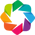

In [273]:
hv.extension('bokeh')
hv.output(size=200)

In [278]:
print(links.head(3))


     country_user iso_country_end  number_of_trips
2117           US              US           122586
1179           JP              JP            10234
96             AU              AU             3638


In [276]:
nodes = hv.Dataset(top_end_country, 'country_user')
nodes.data.head()


country_user iso_country_end  number_of_trips
2117           US              US           122586
1179           JP              JP            10234
96             AU              AU             3638
825            GB              GB             3490
1227           JP              US             2250

In [280]:
links = top_end_country.rename(columns = {'country_user' : 'source', 'iso_country_end' : 'target', 'number_of_trips' : 'value'})

hv.Chord(links)


:Chord   [source,target]   (value)

In [286]:
countries.reset_index()

index iso_country                        country
0        0          AD                        Andorra
1        1          AE           United Arab Emirates
2        2          AF                    Afghanistan
3        3          AG            Antigua and Barbuda
4        4          AI                       Anguilla
..     ...         ...                            ...
241    242          YT                        Mayotte
242    243          ZA                   South Africa
243    244          ZM                         Zambia
244    245          ZW                       Zimbabwe
245    246          ZZ  Unknown or unassigned country

[246 rows x 3 columns]

In [295]:
test = top_end_country.merge(
    countries.reset_index()[["iso_country", "index"]],
    left_on="country_user",
    right_on="iso_country",
).drop(columns="iso_country").rename(columns={'index' : 'source'}).merge(
    countries.reset_index()[["iso_country", "index"]],
    left_on="iso_country_end",
    right_on="iso_country",
).drop(columns="iso_country").rename(columns={'index' : 'target'})

In [298]:
links = test[['source', 'target', 'number_of_trips']]

In [299]:
test.head(2)

country_user iso_country_end  number_of_trips  source  target
0           US              US           122586     228     228
1           JP              US             2250     110     228

In [303]:
nodes_df

index iso_country                        country
0        0          AD                        Andorra
1        1          AE           United Arab Emirates
2        2          AF                    Afghanistan
3        3          AG            Antigua and Barbuda
4        4          AI                       Anguilla
..     ...         ...                            ...
241    242          YT                        Mayotte
242    243          ZA                   South Africa
243    244          ZM                         Zambia
244    245          ZW                       Zimbabwe
245    246          ZZ  Unknown or unassigned country

[246 rows x 3 columns]

In [315]:
links = test[['source', 'target', 'number_of_trips']]
nodes = hv.Dataset(countries.reset_index(), 'index')

chord = hv.Chord((links, nodes)).select(number_of_trips=(1000, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20',
               labels='country'))

:Chord   [source,target]   (number_of_trips)

In [320]:
import chart_studio.plotly as py
import plotly.graph_objects as go

data = [go.Bar(x=df.School,
            y=df.Gap)]

py.iplot(data, filename='jupyter-basic_bar')

ModuleNotFoundError: No module named 'chart_studio'

In [323]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

fig = go.Figure(data=go.Choropleth(
    locations = df['CODE'],
    z = df['GDP (BILLIONS)'],
    text = df['COUNTRY'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP<br>Billions US$',
))

fig.update_layout(
    title_text='2014 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
        showarrow = False
    )]
)

fig.show()

### Check if it is possible to predict user home areas based on their long distance travel patterns?